# Install necessary packages and importing

In [14]:
import functools
import jax
import jax.numpy as jnp
import torch
import optax
import matplotlib.pyplot as plt
import flax
from flax.training import train_state, checkpoints
import flax.linen as nn
from flax.training import train_state

from algebra.cliffordalgebra import CliffordAlgebra
from modules.conv.kernel import CliffordSteerableKernel
from modules.conv.condkernel import CondCliffordSteerableKernel
from modules.conv.convolution import CliffordSteerableConv, ComposedCliffordSteerableConv, ConditionedCliffordSteerableConv, BatchlessConditionedCliffordSteerableConv
from modules.conv.convolution import AltConditionedCliffordSteerableConv
from models.resnets import CSResNet

from escnn import gspaces, group

RNG_ID = 42
# disable 64
jax.config.update("jax_enable_x64", False)

# Plotting trained kernels

## 1. Loading the trained params

In [15]:
checkpoint_dir = "/Users/balints/Documents/CLS/clifford-group-equivariant-cnns/checkpoints/890"

In [16]:
#Model args

algebra = CliffordAlgebra((1, 1))

model_args = dict(
    algebra=algebra,
    time_history=4,
    time_future=1,
    hidden_channels=48,
    kernel_num_layers=4,
    kernel_hidden_dim=12,
    kernel_size=7,
    kernel_type="conditioned",
    bias_dims=(0,),
    product_paths_sum=algebra.geometric_product_paths_sum,
    make_channels=False,
    blocks=(2, 2, 2, 2),
    norm=True
)

model = CSResNet(**model_args)

In [17]:
shape_init = (8, 4, 64, 64, 4)
rng = jax.random.PRNGKey(42)

variables_shape = model.init(rng, jnp.ones(shape_init))['params']


# Loading the checkpoint
state = checkpoints.restore_checkpoint(
    ckpt_dir=checkpoint_dir,
    target=variables_shape,
    prefix='default',
    step=None
    
)

# Extract the parameters
if state is None:
    print("Checkpoint could not be loaded.")
else:
    params = state['params'] if 'params' in state else state
    print(params.keys())

Using 2D non-relativistic pooling
x shape (8, 4, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic pooling
x shape (8, 48, 64, 64, 4)
Using 2D non-relativistic

dict_keys(['ConditionedCliffordSteerableConv_0', 'ConditionedCliffordSteerableConv_1', 'CSBasicBlock_0', 'CSBasicBlock_1', 'CSBasicBlock_2', 'CSBasicBlock_3', 'CSBasicBlock_4', 'CSBasicBlock_5', 'CSBasicBlock_6', 'CSBasicBlock_7', 'ConditionedCliffordSteerableConv_2', 'ConditionedCliffordSteerableConv_3'])


In [18]:
# Slicing into the parameters to get the desired objects
kernel_params = params['ConditionedCliffordSteerableConv_0']['BatchlessConditionedCliffordSteerableConv_0']['CondCliffordSteerableKernel_0']#['WeightedCayley_0']['weight']#['BatchlessConditionedCliffordSteerableConv_0']['CondCliffordSteerableKernel_0']["WeightedCayley_0"]["weight"]

print(kernel_params.keys())

# this is necessary for initialisation
kernel_params = {'params': kernel_params}

dict_keys(['rel_pos_sigma', 'WeightedCayley_0', 'KernelNetwork_0', 'ScalarShell_0'])


## 2. Initialising the kernel with the trained params

Defining the masking functions

In [ ]:
def create_circular_mask(diameter, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = ((diameter-1)/2, (diameter-1)/2)
    if radius is None:
        radius = min(center[0], center[1], diameter-center[0], diameter-center[1])

    Y, X = jnp.ogrid[:diameter, :diameter]
    dist_from_center = jnp.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask.astype(float)

def pool(x, circular_mask):
    return (x * circular_mask[None, :, :, None]).mean((1, 2)) # pool the image into one vector; image has shape [C,X_1,X_2,n_blades] (no batch!)

In [8]:
def create_circular_mask(kernel_size, center=None, radius=None, dim=2):
    """Create circular/spherical mask for 2D/3D"""
    if center is None:
        center = tuple((kernel_size-1)/2 for _ in range(dim))
    if radius is None:
        radius = min(center[0], center[1], kernel_size-center[0], kernel_size-center[1])
    if dim == 2:
        Y, X = jnp.ogrid[:kernel_size, :kernel_size]
        dist_from_center = jnp.sqrt((X - center[0])**2 + (Y-center[1])**2)
    elif dim == 3:
        Z, Y, X = jnp.ogrid[:kernel_size, :kernel_size, :kernel_size]
        dist_from_center = jnp.sqrt((X - center[0])**2 + (Y-center[1])**2 + (Z-center[2])**2)
    else:
        raise ValueError(f"Unsupported dimension: {dim}")
    
    mask = dist_from_center <= radius
    return mask.astype(float)

def pool(x, circular_mask):
    """Pool function that works for both 2D and 3D"""
    # x shape: [C,*spatial_dims,n_blades]
    # For 2D: [C,X_1,X_2,n_blades]
    # For 3D: [C,X_1,X_2,X_3,n_blades]
    
    # Add singleton dimensions to mask for broadcasting
    mask_shape = [1] + list(circular_mask.shape) + [1]
    circular_mask = circular_mask.reshape(mask_shape)
    # Apply mask and average over spatial dimensions
    print(len(x.shape)-1)
    spatial_axes = tuple(range(1, len(x.shape)-1))
    return (x*circular_mask).mean(spatial_axes)

In [19]:
def create_circular_mask(kernel_size, center=None, radius=None, dim=2):
    """Create circular/spherical mask for 2D/3D"""
    if center is None:
        center = tuple((kernel_size-1)/2 for _ in range(dim))
    if radius is None:
        radius = min(center[0], center[1], kernel_size-center[0], kernel_size-center[1])
    if dim == 2:
        Y, X = jnp.ogrid[:kernel_size, :kernel_size]
        dist_from_center = jnp.sqrt((X - center[0])**2 + (Y-center[1])**2)
    elif dim == 3:
        Z, Y, X = jnp.ogrid[:kernel_size, :kernel_size, :kernel_size]
        dist_from_center = jnp.sqrt((X - center[0])**2 + (Y-center[1])**2 + (Z-center[2])**2)
    else:
        raise ValueError(f"Unsupported dimension: {dim}")
    
    mask = dist_from_center <= radius
    return mask.astype(float)

def pool_2d(x, circular_mask, algebra):
    """2D pooling with fixed dimensions"""
    # x shape: [C,X_1,X_2,n_blades]
    # circular_mask shape: [mask_size, mask_size]
    
    # Reshape mask with explicit dimensions
    mask = circular_mask.reshape(1, circular_mask.shape[0], circular_mask.shape[1], 1)
    
    # Apply mask and average over spatial dimensions (1,2)
    return (x * mask).mean(axis=(1, 2))

In [20]:
# Getting algebra object
algebra = CliffordAlgebra((1,1))

In [21]:
kernel_size = 128
c_in = 4
c_out = 48


# Config for instantiation
config = dict(
    algebra=algebra,
    kernel_size=kernel_size,
    c_in=c_in,
    c_out=c_out,
    num_layers=4,
    hidden_dim=12,
    bias_dims=(0,),
    product_paths_sum=algebra.geometric_product_paths.sum().item(),
)

In [4]:
# instantiation
default_kernel = CliffordSteerableKernel(**config)

In [22]:
# instantiation
cond_kernel = CondCliffordSteerableKernel(**config)

## 3. Optaining condition from an NS datapoint

Defining padding function (necessary for plotting)

In [26]:
def preprocess_data_ns(data, clifford):
    if clifford:
        # Concatenate zeros to the tensor
        zero_pad = torch.zeros(data.shape[:-1] + (1,))
        data = torch.cat((data, zero_pad), dim=-1)

    return data

Loading data from (drive) folder

In [23]:
# Specify the path to the .pt file you want to load
pt_file_path = "/Users/balints/Documents/CLS/Clifford-Steerable-CNNs/clifford-group-equivariant-cnns/115.pt "

# Load the data from the .pt file
data_tensor = torch.load(pt_file_path)  # Shape: (T, 64, 64, C)

print("Loaded data tensor shape:", data_tensor.shape)

Loaded data tensor shape: torch.Size([14, 64, 64, 3])


/var/folders/x0/045gfpv12wn4v06hs4bt6q9h0000gn/T/ipykernel_74661/3953346227.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_tensor = torch.load(pt_file_path)  # Sha

In [24]:
# Extracting the data for num_timesteps
num_timepoints = c_in

if data_tensor.shape[0] < num_timepoints:
    raise ValueError(f"Not enough timepoints available. Requested {num_timepoints}, but the tensor only has {data_tensor.shape[0]}.")
condition_timesteps = data_tensor[:num_timepoints]  # Shape: (4, 64, 64, 3)

print("Condition timesteps shape:", condition_timesteps.shape)

Condition timesteps shape: torch.Size([4, 64, 64, 3])


We need to pad the pseudoscalar part with zeros since the data doesn't contain that part.

We also transform the torch tensor to a jax array

In [27]:
# Padding the data
input_padded = preprocess_data_ns(condition_timesteps, True)
print(input_padded.shape)

# Moving torch tensor to jax
input = jnp.array(input_padded)
print(input.shape)

torch.Size([4, 64, 64, 4])
(4, 64, 64, 4)


In [5]:
#or random input
input = jax.random.normal(jax.random.PRNGKey(RNG_ID), (1, 32, 32, 4))
#input = jnp.ones((1, 32, 32, 4))
print(input.shape)

(1, 32, 32, 4)


In [28]:
def generate_kernel_grid(kernel_size, dim):
    """
    Generate the 2D or 3D grid for a given kernel size.

    Args:
        kernel_size (int): The size of the kernel.
        dim (int): The dimension of the grid.

    Returns:
        jnp.ndarray: The grid of shape (kernel_size ** dim, dim) defined on the range [-1, 1]^dim.
    """
    axes = [jnp.arange(0, kernel_size) for _ in range(dim)]
    grid = jnp.stack(jnp.meshgrid(*axes, indexing="ij"), axis=-1)
    grid = grid - kernel_size // 2
    return grid.reshape(-1, dim) / max(kernel_size // 2, 1.0)

def orthogonal_grid(grid: jnp.ndarray) -> jnp.ndarray:
    """
    Given the displacement grid generated by `generate_kernel_grid`,
    return a grid of grade‑1 vectors that are point‑wise orthogonal
    to the original displacements.

    Parameters
    ----------
    grid : jnp.ndarray
        Shape (N, dim) with dim ∈ {2,3}.  Each row is v = (v₁,…,v_dim).

    Returns
    -------
    jnp.ndarray
        Same shape (N, dim).  Each row is a vector c that satisfies
        v·c = 0  and ‖c‖ = ‖v‖ (for dim = 2) or ‖c‖ ≤ ‖v‖ (for dim = 3).
    """
    dim = grid.shape[1]

    if dim == 2:
        # 90° rotation: (x, y) ⟶ (−y, x)
        v_x, v_y = grid[:, 0], grid[:, 1]
        c = jnp.stack((-v_y, v_x), axis=1)

    elif dim == 3:
        # for each v choose a fixed, non‑colinear helper w and take v×w
        v_x, v_y, v_z = grid[:, 0], grid[:, 1], grid[:, 2]

        # use w=(0,0,1) unless v is parallel to e3; fall back to w=(0,1,0)
        use_e2 = jnp.isclose(jnp.abs(v_z), jnp.linalg.norm(grid, axis=1))
        w = jnp.where(use_e2[:, None],
                      jnp.array([0.0, 1.0, 0.0]),
                      jnp.array([0.0, 0.0, 1.0]))
        c = jnp.cross(grid, w)

    else:
        raise ValueError("Only 2‑D or 3‑D grids are supported.")

    return c

def compute_scalar_shell(algebra: object, v: jnp.ndarray):
    """
    Compute scalar shell for the output of the kernel network given a vector.

    Args:
        algebra (object): An instance of CliffordAlgebra defining the algebraic structure.
        v (jnp.ndarray): The input vector of shape (N, 1, algebra.dim).
        sigma (jnp.ndarray): The array of kernel widths.
            - last dimension can be 2**algebra.dim or 1.

    Returns:
        jnp.ndarray: The output scalar of shape (N, 1, 1).
    """
    sigma = jnp.ones((1, 1))
    q_v = algebra.q(algebra.embed_grade(v, 1))
    sgn = jnp.where(q_v >= 0, 1, -1)
    return sgn * jnp.exp(-jnp.abs(q_v) / (2 * sigma**2))

In [158]:
kernel_size = 32
grid = generate_kernel_grid(kernel_size, 2)
orthogonal_grid = orthogonal_grid(grid)
print(orthogonal_grid.shape)
print(grid.shape)

scalars = compute_scalar_shell(algebra, grid)
print(scalars.shape)
scalars_orthogonal = compute_scalar_shell(algebra, orthogonal_grid)
print(scalars_orthogonal.shape)

bivector_pads = jnp.zeros((scalars.shape))
print(bivector_pads.shape)

grid = grid.reshape(kernel_size, kernel_size, 2)
print(grid.shape)

orthogonal_grid = orthogonal_grid.reshape(kernel_size, kernel_size, 2)
print(orthogonal_grid.shape)

scalars_orthogonal = scalars_orthogonal.reshape(kernel_size, kernel_size, 1)
print(scalars_orthogonal.shape)

bivector_pads = bivector_pads.reshape(kernel_size, kernel_size, 1)
print(bivector_pads.shape)



(1024, 2)
(1024, 2)
(1024, 1)
(1024, 1)
(1024, 1)
(32, 32, 2)
(32, 32, 2)
(32, 32, 1)
(32, 32, 1)


In [159]:
input = jnp.concatenate((scalars_orthogonal, orthogonal_grid, bivector_pads), axis=2)
print(input.shape)

input = input[jnp.newaxis,:,:,:]
print(input.shape)


(32, 32, 4)
(1, 32, 32, 4)


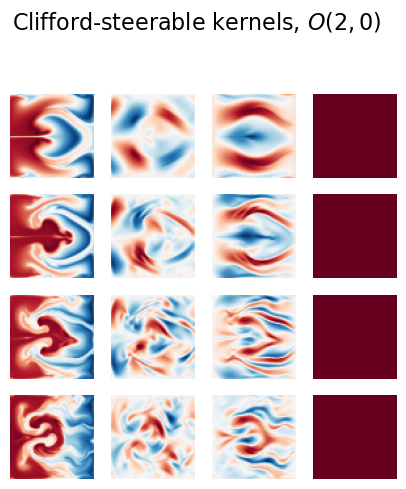

In [42]:
fig, ax = plt.subplots(4, 4, figsize=(5, 5))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(input[i, :, :, j], cmap="RdBu")
        ax[i, j].axis("off")

fig.suptitle("Clifford-steerable kernels, $O(2,0)$", fontsize=16, y=1.05)
plt.show()

Now we need to obtain the condition from the input

In [43]:
# Create the circular mask
circular_mask = create_circular_mask(input.shape[-2]) #we need the diamater to be the same size as the domain dims

# Obtain condition
condition = pool_2d(input, circular_mask, algebra)

print("Shape of the condition", condition.shape)

Shape of the condition (4, 4)


In [11]:
#init default with random params
default_kernel_params = default_kernel.init(jax.random.PRNGKey(RNG_ID))

In [14]:
#Default init with random params

init = default_kernel.apply(default_kernel_params)
print(init[0].shape)
init = init[0]

(4, 4, 128, 128)


In [ ]:
#Conditioned init with trained params
kernel_params = cond_kernel.init(kernel_params, condition)

In [51]:
init = cond_kernel.apply(kernel_params, condition)
print(init.shape)

(192, 16, 128, 128)


In [91]:
c_out = int(init.shape[0]/algebra.n_blades)
c_in = int(init.shape[1]/algebra.n_blades)
init_plot = init.reshape(c_out, algebra.n_blades,c_in, algebra.n_blades, 128, 128).transpose(0, 2, 1, 3, 4, 5)
print(init_plot.shape)

(48, 4, 4, 4, 128, 128)


In [ ]:
#conditioned init with random params
kernel_params = cond_kernel.init(jax.random.PRNGKey(RNG_ID), condition)

## 4. Plotting the trained kernels

Now we visualise the trained kernels for each input and output channel, conditioning on the sample from the NS testing dataset

In [107]:
c_in_list = list(range(init_plot.shape[1]))
c_out_list = list(range(init_plot.shape[0]))

for cin in c_in_list:
    for cout in c_out_list:
        fig, ax = plt.subplots(4, 4, figsize=(5, 5))
        for i in range(4):
            for j in range(3, -1, -1):
                ax[i, j].imshow(init_plot[cout, cin, i, j], cmap="RdBu")
                ax[i, j].axis("off")
        fig.tight_layout()
        plt.savefig(f"/Users/balints/Documents/CLS/clifford-group-equivariant-cnns/kernels_{cout}_{cin}.png")
        plt.close(fig)

# Equivariance check

In this section we check the equivariance error of a randomly initialised conditioned convolution layer

## 1. Load trained or random init convolutional layer

In [16]:
# Mounting drive (optional)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/composed-exp/checkpoints/bcf87sod/986"

In [ ]:
# Loading the checkpoint
state = checkpoints.restore_checkpoint(
    ckpt_dir=checkpoint_dir,
    target=None,
    prefix='default',
    step=None
)

# Extract the parameters
if state is None:
    print("Checkpoint could not be loaded.")
else:
    params = state['params'] if 'params' in state else state
    print(params.keys())

In [166]:
# get algebra object if not already
algebra = CliffordAlgebra((1,1))

# set the parameters
c_in = 4
c_out = 1
kernel_size = 7
mask_size = 32 # domain size
num_layers = 4
hidden_dim = 12
bias_dims = (0,)
product_paths_sum = algebra.geometric_product_paths.sum().item()
batch_size = 16


In [ ]:
# Slicing into the parameters to get the desired objects
conv_params = params['model']['params']['CSBasicBlock_0']['ConditionedCliffordSteerableConv_0']['BatchlessConditionedCliffordSteerableConv_0']#['CondCliffordSteerableKernel_0']['rel_pos_sigma']
print(conv_params.keys())

# this is necessary for initialisation
conv_params = {'params': conv_params}

dict_keys(['CondCliffordSteerableKernel_0', 'bias'])


In [12]:
cconv = BatchlessConditionedCliffordSteerableConv(
    algebra=algebra,
    c_in=c_in,
    c_out=c_out,
    kernel_size=kernel_size,
    mask_size = mask_size,
    bias_dims=bias_dims,
    product_paths_sum=product_paths_sum,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    padding=True,
    stride=1,
    bias=True if bias_dims is not None else False,
)

In [17]:
cconv_batched = ConditionedCliffordSteerableConv(
    algebra=algebra,
    c_in=c_in,
    c_out=c_out,
    kernel_size=kernel_size,
    bias_dims=bias_dims,
    product_paths_sum=product_paths_sum,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    padding=True,
    stride=1,
    bias=True if bias_dims is not None else False,
    mask_size=mask_size,
)

In [167]:
cconv_batched = AltConditionedCliffordSteerableConv(
    algebra=algebra,
    c_in=c_in,
    c_out=c_out,
    kernel_size=kernel_size,
    bias_dims=bias_dims,
    product_paths_sum=product_paths_sum,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    padding=True,
    stride=1,
    bias=True if bias_dims is not None else False,
    mask_size=mask_size,
)

In [4]:
cconv_batched = CliffordSteerableConv(
    algebra=algebra,
    c_in=c_in,
    c_out=c_out,
    kernel_size=kernel_size,
    bias_dims=bias_dims,
    product_paths_sum=product_paths_sum,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    padding=True,
    stride=1,
    bias=True if bias_dims is not None else False,
    mask_size=mask_size,
)

In [7]:
cconv_batched = ComposedCliffordSteerableConv(
    algebra=algebra,
    c_in=c_in,
    c_out=c_out,
    kernel_size=kernel_size,
    bias_dims=bias_dims,
    product_paths_sum=product_paths_sum,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    padding=True,
    stride=1,
    bias=True if bias_dims is not None else False,
)

## 2. Cl(2)

### 2a. Set up an input and transformed input field (can also load it from ns set as seen above)

In [168]:
#alternatively use example input

# Initialize the grid
x, y = jnp.meshgrid(
    jnp.linspace(0, 2 * jnp.pi, mask_size), jnp.linspace(0, 2 * jnp.pi, mask_size)
)

scalar = jnp.sin(x) + jnp.cos(y)
vector_x = jnp.sin(x) * jnp.sin(y) + jnp.cos(x)
vector_y = jnp.cos(x) + jnp.cos(y) ** 2
bivector = jnp.cos(x) - jnp.sin(y)

mv_field = jnp.stack([scalar, vector_x, vector_y, bivector], axis=-1)
mv_field = jnp.expand_dims(mv_field, axis=[0])

input = jnp.repeat(mv_field, c_in, axis=0)
print(input.shape)

#batched implementation
input_batched = jnp.repeat(input[jnp.newaxis, ...], batch_size, axis=0)
print(input_batched.shape)


(4, 32, 32, 4)
(16, 4, 32, 32, 4)


In [19]:
#batched implementation
conv_params_batched = cconv_batched.init(jax.random.PRNGKey(RNG_ID), input_batched)

Using 2D non-relativistic pooling


In [20]:
conv_params = cconv.init(jax.random.PRNGKey(RNG_ID), input)

NameError: name 'cconv' is not defined

Different transformations are only necessary if $c_{in} \neq c_{out}$

In [21]:
gspace = gspaces.flipRot2dOnR2(4)
print(gspace.fibergroup.irreps())
scalar, pseudoscalar, vector = gspace.fibergroup.irreps()[
    :3
]  # multivector grades 0, 1, 2
representation = group.directsum(
    [scalar, vector, pseudoscalar]
)  # multivector representation is a direct sum of the irreps
mv_type_in = gspace.type(
    *(c_in*[representation])
)  # this is the type of the field in the language of escnn

print(mv_type_in)

mv_type_out = gspace.type(
    *(c_out*[representation]))
print(mv_type_out)

[D4|[irrep_0,0]:1, D4|[irrep_1,0]:1, D4|[irrep_1,1]:2, D4|[irrep_1,2]:1, D4|[irrep_0,2]:1]
[D4_on_R2[(3.141592653589793, 4)]: {[irrep_0,0]_[irrep_1,1]_[irrep_1,0] (x4)}(16)]
[D4_on_R2[(3.141592653589793, 4)]: {[irrep_0,0]_[irrep_1,1]_[irrep_1,0] (x1)}(4)]


In [22]:
def to_geometric_tensor_torched(mv, ftype):
    """
    Converts a multivector jnp array to a torch tensor and defines the corresponding escnn' geometric tensor.

    Args:
        mv: jnp.array of shape (batch, channel, height, width, algebra.n_subspaces).
        ftype: escnn.FieldType, the type of the field.

    Returns:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width) and type ftype.
    """
    mv = torch.tensor(mv.__array__(), dtype=torch.float32)
    mv = mv.permute(0, 1, -1, 2, 3)
    mv = mv.reshape(mv.shape[0], -1, mv.shape[-2], mv.shape[-1])
    mv = ftype(mv)
    return mv


def to_mv_jaxed(mv):
    """
    Converts a torch tensor to a multivector jnp array.

    Args:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width) and type ftype.

    Returns:
        mv: jnp.array of shape (batch, channel, height, width, algebra.n_subspaces).
    """
    mv = mv.tensor
    mv = mv.reshape(mv.shape[0], -1, 4, mv.shape[-2], mv.shape[-1])
    mv = mv.permute(0, 1, 3, 4, 2)
    mv = jnp.array(mv.numpy(), dtype=jnp.float32)
    return mv

In [23]:
mv_gt_batched = to_geometric_tensor_torched(input_batched, mv_type_in)
print(mv_gt_batched.tensor.shape)

torch.Size([2, 16, 32, 32])


In [24]:
g_out = list(gspace.testing_elements)[1]
g_in = list(gspace.testing_elements)[1]
#mv_gt_transformed_in = mv_gt.transform(g_in)
mv_gt_transformed_in_batched = mv_gt_batched.transform(g_in)

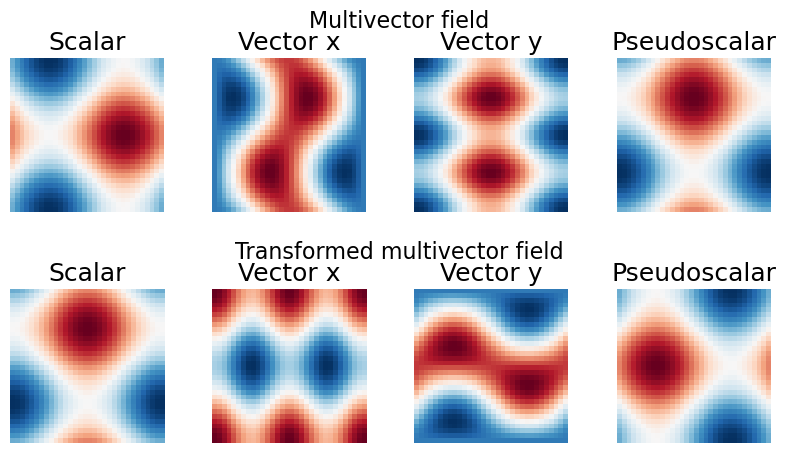

In [25]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y", "Pseudoscalar"]

reshaped_mv_gt = mv_gt_batched.tensor.reshape(
    mv_gt_batched.tensor.shape[0], c_in, 4, mv_gt_batched.tensor.shape[-2], mv_gt_batched.tensor.shape[-1])
reshaped_mv_gt_transformed = mv_gt_transformed_in_batched.tensor.reshape(
    mv_gt_transformed_in_batched.tensor.shape[0],c_in, 4, mv_gt_transformed_in_batched.tensor.shape[-2], mv_gt_transformed_in_batched.tensor.shape[-1])

for i in range(4):
    ax[0, i].imshow(reshaped_mv_gt[0, 0, i, :, :], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(4):
    ax[1, i].imshow(reshaped_mv_gt_transformed[0, 0, i, :, :], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(
    -0.1,
    1.2,
    "Multivector field",
    ha="center",
    fontsize=16,
    transform=ax[0, 2].transAxes,
)
plt.text(
    -0.1,
    1.2,
    "Transformed multivector field",
    ha="center",
    fontsize=16,
    transform=ax[1, 2].transAxes,
)
plt.show()

### 2b. Apply transformations and compute relative error

In [26]:
#batched implementation

# 1) rotation -> 2) convolution
rotated_input_batched = to_mv_jaxed(mv_gt_transformed_in_batched)

print(rotated_input_batched.shape)

out_rotated_conv_batched = to_geometric_tensor_torched(
    cconv_batched.apply(conv_params_batched, rotated_input_batched), mv_type_out
)

# 2) convolution -> 2) rotation

conv_out_batched = cconv_batched.apply(conv_params_batched, input_batched)
print(conv_out_batched.shape)

out_conv_rotated_batched = to_geometric_tensor_torched(conv_out_batched, mv_type_out).transform(g_out)

print(out_rotated_conv_batched.tensor.shape)
print(out_conv_rotated_batched.tensor.shape)


(2, 4, 32, 32, 4)
Using 2D non-relativistic pooling
Using 2D non-relativistic pooling
(2, 1, 32, 32, 4)
torch.Size([2, 4, 32, 32])
torch.Size([2, 4, 32, 32])


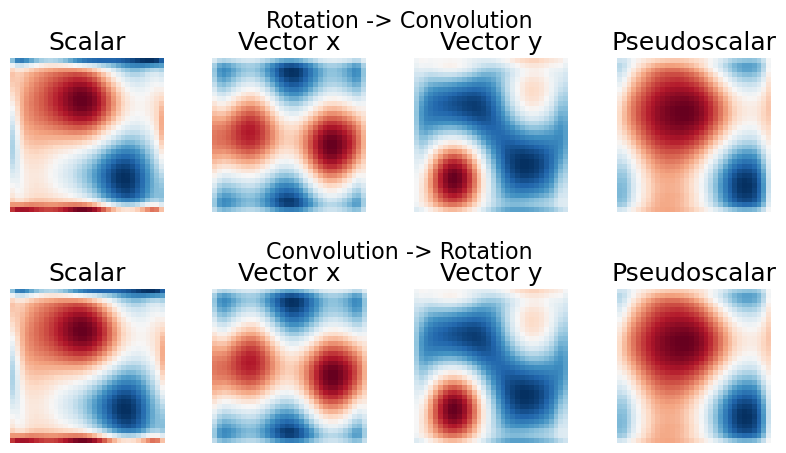

In [27]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y", "Pseudoscalar"]

reshaped_out_rotated_conv = out_rotated_conv_batched.tensor.reshape(out_rotated_conv_batched.tensor.shape[0], c_out, 4, out_rotated_conv_batched.tensor.shape[-2], out_rotated_conv_batched.tensor.shape[-1])
reshaped_out_conv_rotated = out_conv_rotated_batched.tensor.reshape(out_conv_rotated_batched.tensor.shape[0], c_out, 4, out_conv_rotated_batched.tensor.shape[-2], out_conv_rotated_batched.tensor.shape[-1])

for i in range(4):
    ax[0, i].imshow(reshaped_out_rotated_conv[0, 0, i, :, :], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(4):
    ax[1, i].imshow(reshaped_out_conv_rotated[0, 0,i, :, :], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(
    -0.1,
    1.2,
    "Rotation -> Convolution",
    ha="center",
    fontsize=16,
    transform=ax[0, 2].transAxes,
)
plt.text(
    -0.1,
    1.2,
    "Convolution -> Rotation",
    ha="center",
    fontsize=16,
    transform=ax[1, 2].transAxes,
)
plt.show()

In [28]:
#batched implementation

# Compute relative error for cconv
print(torch.min(torch.abs(out_rotated_conv_batched.tensor + out_conv_rotated_batched.tensor)))  # Check for zeros
print(torch.max(torch.abs(out_rotated_conv_batched.tensor + out_conv_rotated_batched.tensor)))  # Check overall scale

epsilon = 1e-10  # Small constant
relative_error_batched = torch.abs(
    out_rotated_conv_batched.tensor - out_conv_rotated_batched.tensor
) / (torch.abs(out_rotated_conv_batched.tensor + out_conv_rotated_batched.tensor) + epsilon)

# display up to 5 decimal places
print(f"Relative error (mean): {relative_error_batched.mean().item():.1e}")
print(f"Relative error (max): {relative_error_batched.max().item():.1e}")

tensor(0.0003)
tensor(7.3434)
Relative error (mean): 2.3e-06
Relative error (max): 3.3e-03


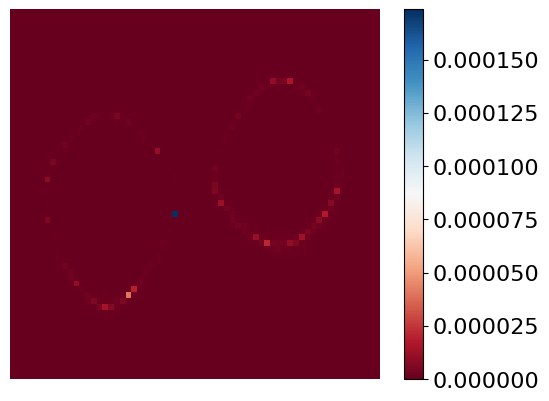

In [17]:
plt.imshow(torch.clip(relative_error_batched[0, 1, :, :], 0, 0.1), cmap="RdBu")
plt.axis("off")
plt.colorbar()
plt.show()

## 3. Cl(3)

### 3a. Set up an input and transformed input field (can also load it from Maxwell dataset)

In [17]:
# Initialize the 3D grid
x, y, z = jnp.meshgrid(
    jnp.linspace(0, 2 * jnp.pi, mask_size),
    jnp.linspace(0, 2 * jnp.pi, mask_size),
    jnp.linspace(0, 2 * jnp.pi, mask_size)
)

# Grade 0: scalar
scalar = jnp.sin(x) + jnp.cos(y) + jnp.sin(z)

# Grade 1: vector components (e1, e2, e3)
vector_1 = jnp.sin(x) * jnp.sin(y) + jnp.cos(z)    # e1
vector_2 = jnp.cos(x) + jnp.cos(y) * jnp.sin(z)    # e2
vector_3 = jnp.sin(x + y) + jnp.cos(z - y)         # e3

# Grade 2: bivector components (e12, e13, e23)
bivector_12 = jnp.cos(x) - jnp.sin(y) + jnp.cos(z)  # e12
bivector_13 = jnp.sin(2*x) + jnp.cos(2*z)           # e13
bivector_23 = jnp.cos(y*z) + jnp.sin(x+y)           # e23

# Grade 3: trivector (e123)
trivector = jnp.sin(x*y*z) - jnp.cos(x+y+z)         # e123

# Stack all components
mv_field = jnp.stack([
    scalar,         # 1
    vector_1,       # e1
    vector_2,       # e2
    vector_3,       # e3
    bivector_12,    # e12
    bivector_13,    # e13
    bivector_23,    # e23
    trivector       # e123
], axis=-1)

print(mv_field.shape)

input = jnp.repeat(mv_field[jnp.newaxis, ...], c_in, axis=0)
print(input.shape)

input_batched = jnp.repeat(input[jnp.newaxis, ...], batch_size, axis=0)
print(input_batched.shape)

(64, 64, 64, 8)
(4, 64, 64, 64, 8)
(8, 4, 64, 64, 64, 8)


In [18]:
#batched implementation
conv_params_batched = cconv_batched.init(jax.random.PRNGKey(RNG_ID), input_batched)

In [6]:
# For 3D rotations
gspace = gspaces.flipRot3dOnR3(4)
irreps = gspace.fibergroup.irreps()
print(irreps)
print(irreps[2])
irreps = gspace.fibergroup.irreps()
for i, irrep in enumerate(irreps):
    print(f"Irrep {i}: {irrep}")

representation_cl3 = group.directsum([
    irreps[0],  # scalar: l=0, p=0 (1D)
    irreps[6],  # vector: l=1, p=1 (3D)
    irreps[1],  # bivector: l=1, p=0 (3D)
    irreps[5]   # trivector: l=0, p=1 (1D)
])
print("\nTotal representation dimension:", representation_cl3.size)

# Create the field types
mv_type_in = gspace.type(*(c_in*[representation_cl3]))
mv_type_out = gspace.type(*(c_out*[representation_cl3]))
print(mv_type_in)
print(mv_type_out)
print("\nField type size:", mv_type_in.size)
print("Expected size (c_in * 8):", c_in * 8)

[O(3)|[irrep_0,0]:1, O(3)|[irrep_0,1]:3, O(3)|[irrep_0,2]:5, O(3)|[irrep_0,3]:7, O(3)|[irrep_0,4]:9, O(3)|[irrep_1,0]:1, O(3)|[irrep_1,1]:3, O(3)|[irrep_1,2]:5, O(3)|[irrep_1,3]:7, O(3)|[irrep_1,4]:9]
O(3)|[irrep_0,2]:5
Irrep 0: O(3)|[irrep_0,0]:1
Irrep 1: O(3)|[irrep_0,1]:3
Irrep 2: O(3)|[irrep_0,2]:5
Irrep 3: O(3)|[irrep_0,3]:7
Irrep 4: O(3)|[irrep_0,4]:9
Irrep 5: O(3)|[irrep_1,0]:1
Irrep 6: O(3)|[irrep_1,1]:3
Irrep 7: O(3)|[irrep_1,2]:5
Irrep 8: O(3)|[irrep_1,3]:7
Irrep 9: O(3)|[irrep_1,4]:9

Total representation dimension: 8
[O(3)_on_R3[o3]: {[irrep_0,0]_[irrep_1,1]_[irrep_0,1]_[irrep_1,0] (x4)}(32)]
[O(3)_on_R3[o3]: {[irrep_0,0]_[irrep_1,1]_[irrep_0,1]_[irrep_1,0] (x1)}(8)]

Field type size: 32
Expected size (c_in * 8): 32


In [7]:
def to_geometric_tensor_torched_3d(mv, ftype):
    """
    Converts a multivector jnp array to a torch tensor and defines the corresponding escnn' geometric tensor.

    Args:
        mv: jnp.array of shape (batch, channel, height, width, depth, algebra.n_subspaces).
        ftype: escnn.FieldType, the type of the field.

    Returns:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width, depth) and type ftype.
    """
    mv = torch.tensor(mv.__array__(), dtype=torch.float32)
    
    # Reshape to combine channels and components
    batch, channels, h, w, d, components = mv.shape
    mv = mv.permute(0, 1, 5, 2, 3, 4)
    mv = mv.reshape(batch, channels * components, h, w, d)
    
    mv = ftype(mv)
    return mv

def to_mv_jaxed_3d(mv):
    """
    Converts a torch tensor to a multivector jnp array.

    Args:
        mv: escnn.GeometricTensor with tensor of shape (batch, channel*algebra.n_subspaces, height, width, depth) and type ftype.

    Returns:
        mv: jnp.array of shape (batch, channel, height, width, depth, algebra.n_subspaces).
    """
    mv = mv.tensor
    
    # Get dimensions
    batch, total_channels, h, w, d = mv.shape
    channels = total_channels // 8  # 8 components for Cl(3)
    
    # Reshape to separate channels and components
    mv = mv.reshape(batch, channels, 8, h, w, d)
    mv = mv.permute(0, 1, 3, 4, 5, 2)
    
    mv = jnp.array(mv.numpy(), dtype=jnp.float32)
    return mv

### 3a. Apply Transformation and compute relative equiv error

In [8]:
mv_gt_batched = to_geometric_tensor_torched_3d(input_batched, mv_type_in)
print(mv_gt_batched.tensor.shape)

torch.Size([8, 32, 64, 64, 64])


In [9]:
g_out = list(gspace.testing_elements)[6]
g_in = list(gspace.testing_elements)[6]
#mv_gt_transformed_in = mv_gt.transform(g_in)
mv_gt_transformed_in_batched = mv_gt_batched.transform(g_in)
print(g_in)

     [ 0.,  1.,  0.],
(+), [ 0.,  0., -1.],
     [-1.,  0.,  0.]


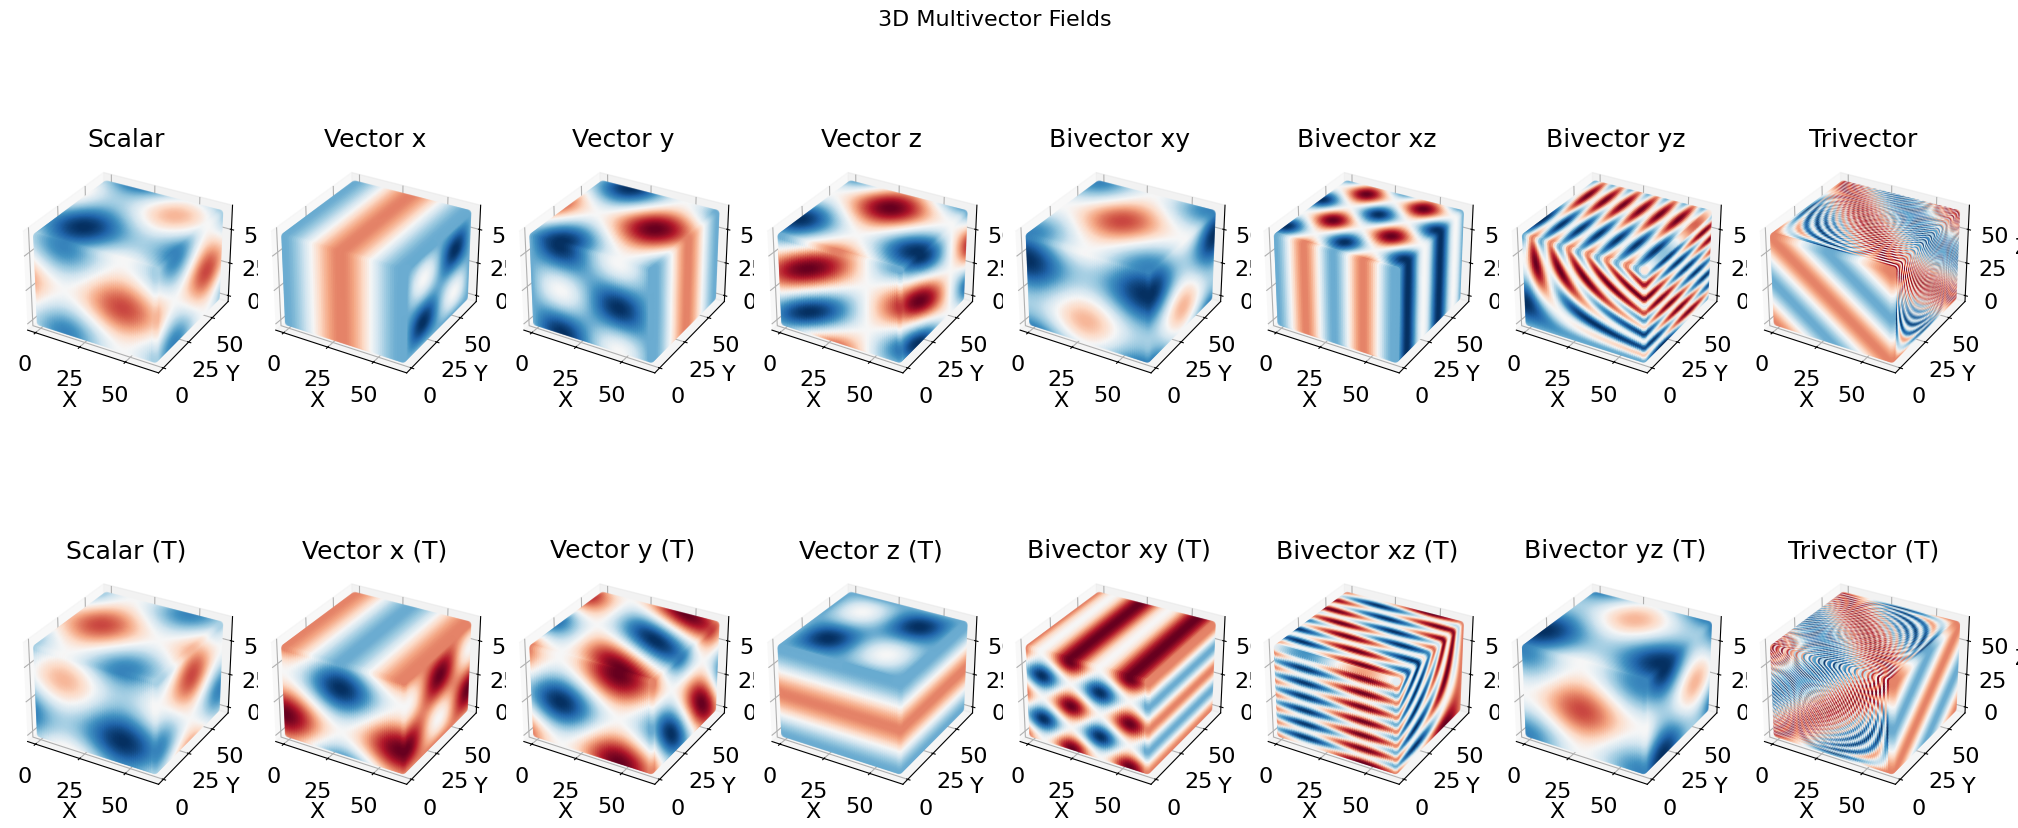

In [10]:
import torch
import matplotlib.pyplot as plt

# Component names (adjust as needed)
component_names = ["Scalar", "Vector x", "Vector y", "Vector z", 
                  "Bivector xy", "Bivector xz", "Bivector yz", "Trivector"]

# Reshape the tensors
reshaped_mv_gt = mv_gt_batched.tensor.reshape(
    mv_gt_batched.tensor.shape[0], c_in, 8, mv_gt_batched.tensor.shape[-3], 
    mv_gt_batched.tensor.shape[-2], mv_gt_batched.tensor.shape[-1]
)
reshaped_mv_gt_transformed = mv_gt_transformed_in_batched.tensor.reshape(
    mv_gt_transformed_in_batched.tensor.shape[0], c_in, 8, 
    mv_gt_transformed_in_batched.tensor.shape[-3], 
    mv_gt_transformed_in_batched.tensor.shape[-2], 
    mv_gt_transformed_in_batched.tensor.shape[-1]
)

# Create figure
fig = plt.figure(figsize=(20, 10))

for i in range(8):  # Iterate over the components
    # Original multivector field
    ax1 = fig.add_subplot(2, 8, i + 1, projection="3d")
    ax1.set_title(component_names[i])
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    # Extract the 3D field for the current component
    field_gt = reshaped_mv_gt[0, 0, i, :, :, :].cpu().numpy()
    z, y, x = torch.meshgrid(
        torch.arange(field_gt.shape[0]),
        torch.arange(field_gt.shape[1]),
        torch.arange(field_gt.shape[2]),
        indexing="ij",
    )
    ax1.scatter(x, y, z, c=field_gt.flatten(), cmap="RdBu")

    # Transformed multivector field
    ax2 = fig.add_subplot(2, 8, i + 9, projection="3d")
    ax2.set_title(component_names[i] + " (T)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    # Extract the 3D field for the current component
    field_transformed = reshaped_mv_gt_transformed[0, 0, i, :, :, :].cpu().numpy()
    ax2.scatter(x, y, z, c=field_transformed.flatten(), cmap="RdBu")

# Add space between rows and adjust layout
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle("3D Multivector Fields", fontsize=16, y=0.95)
plt.tight_layout()
plt.show()


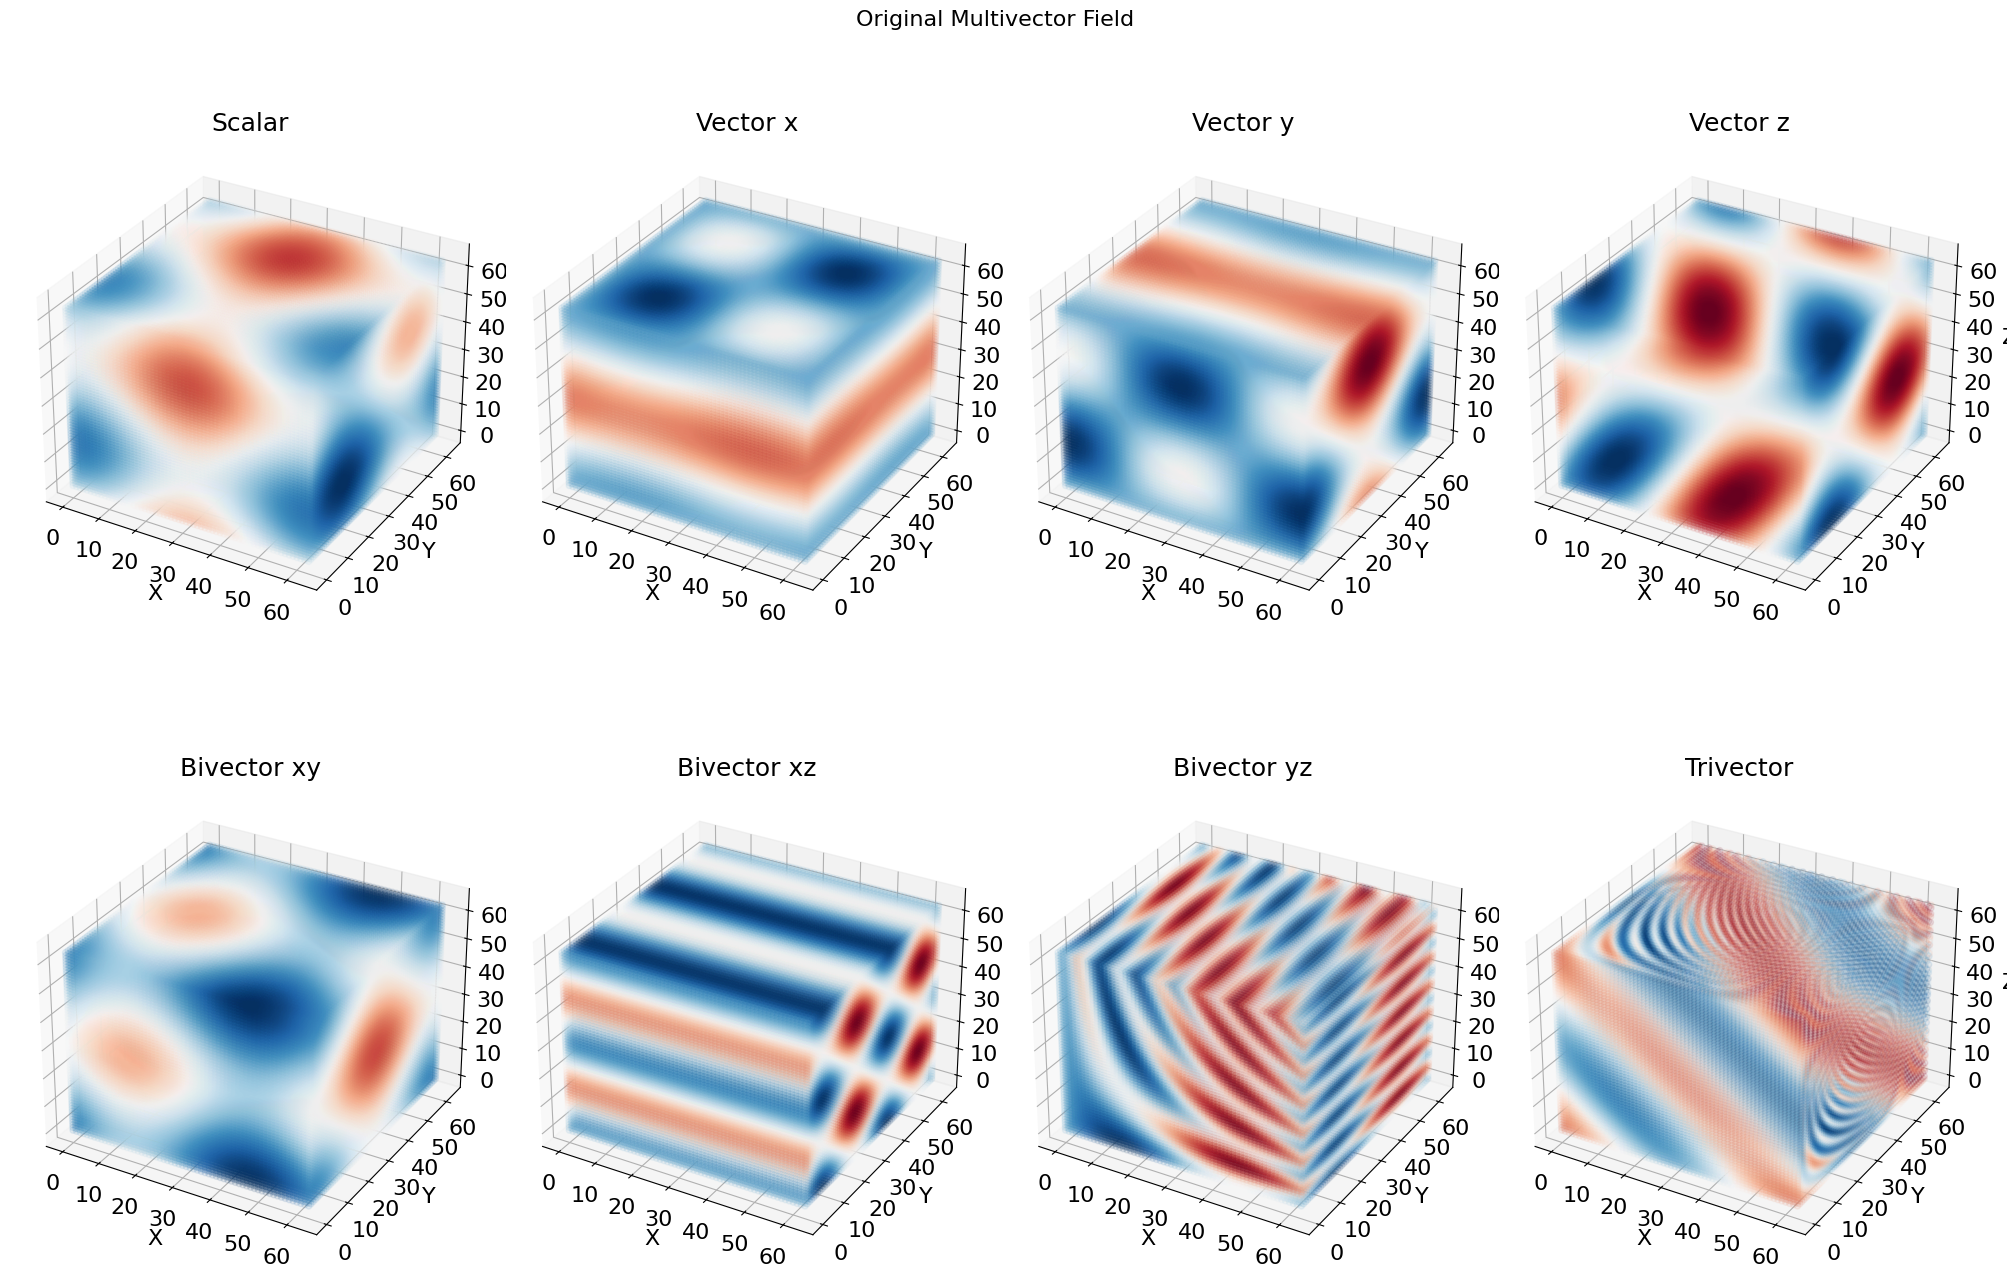

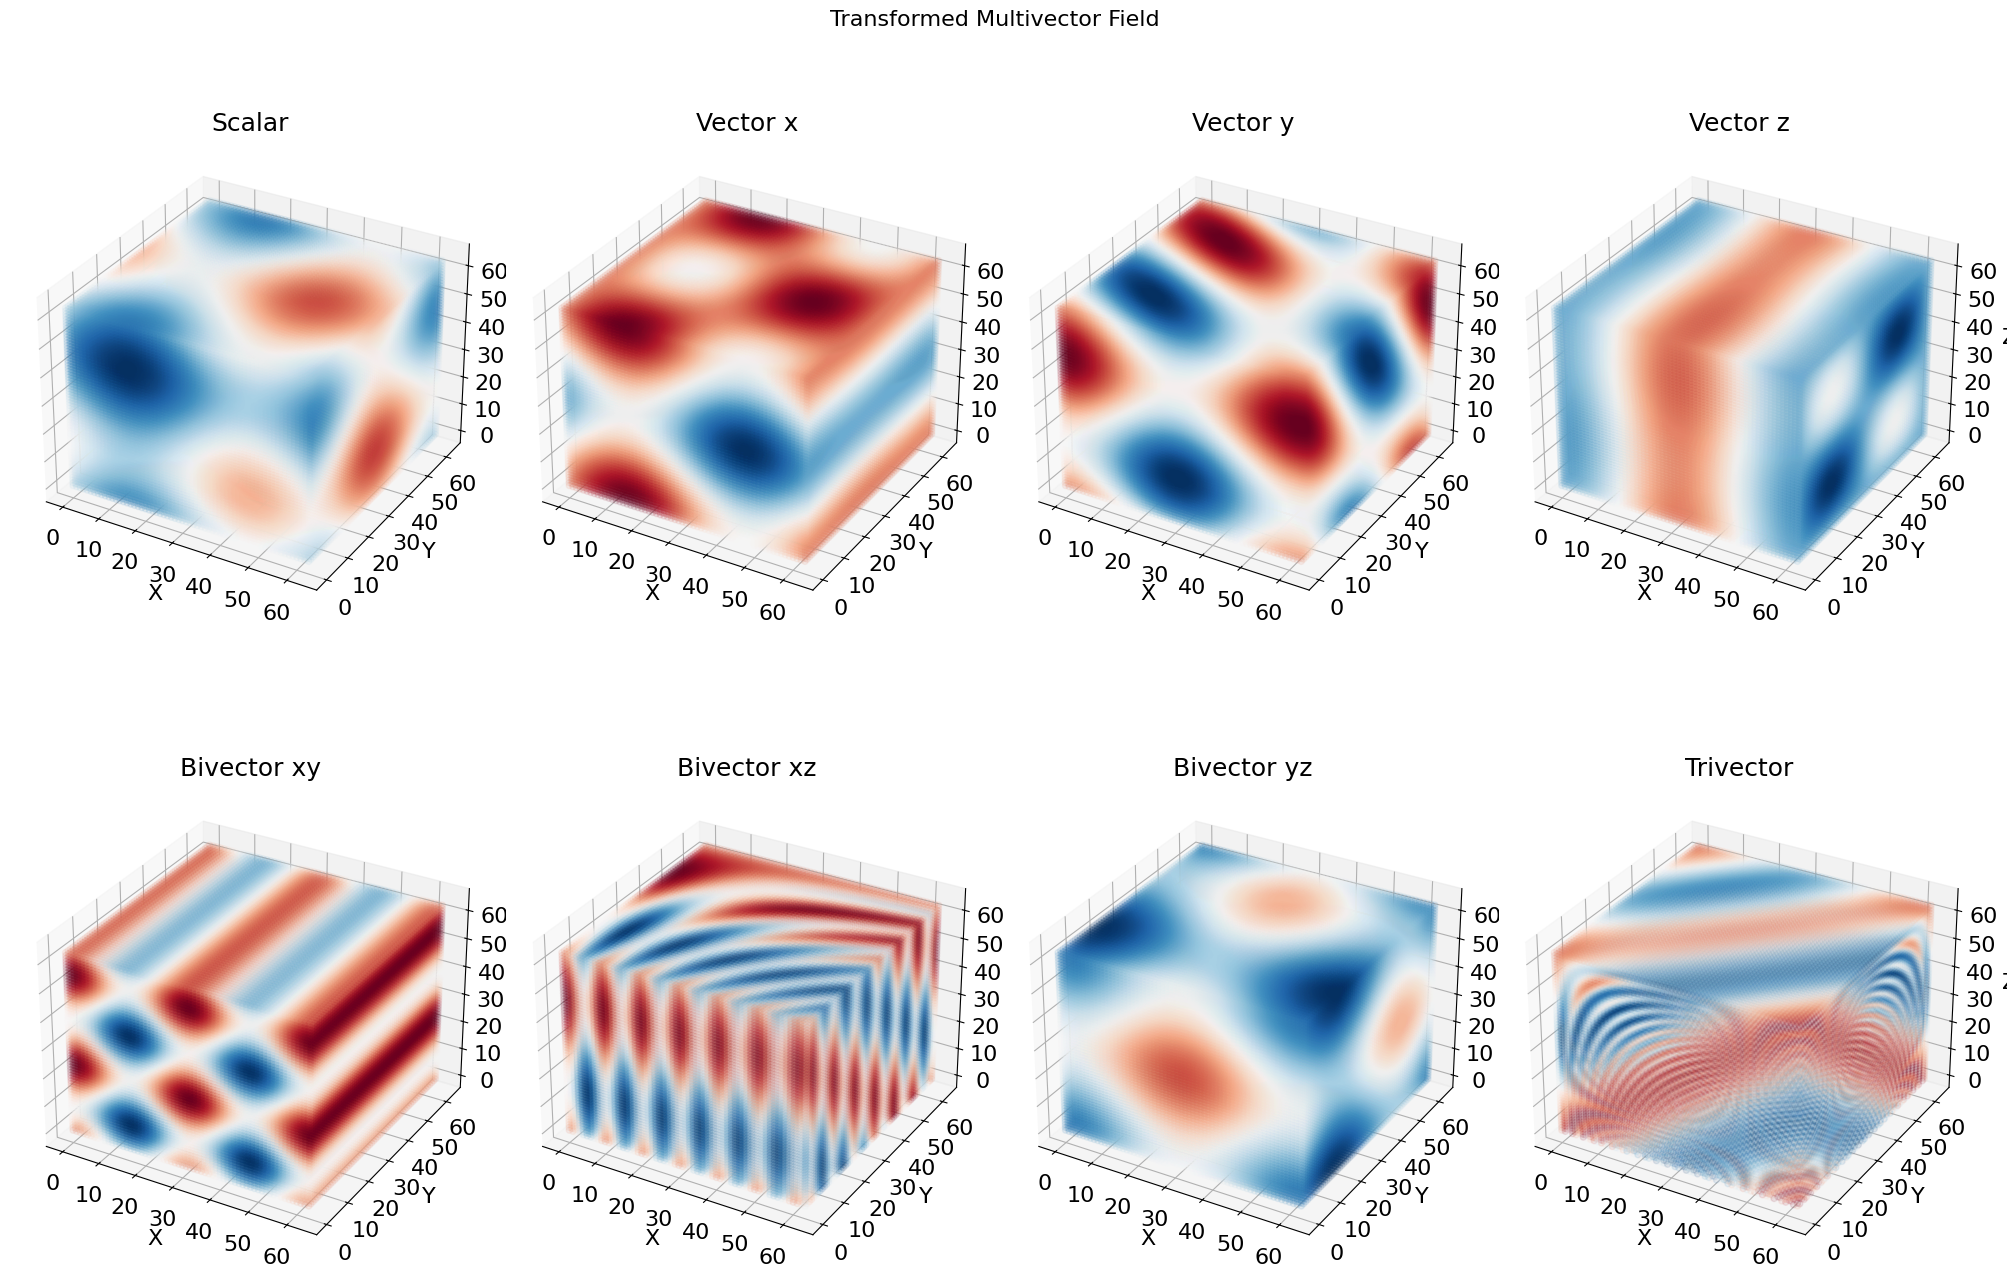

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_field(tensor, component_names, title):
    """
    Plot 3D field with axes.
    Args:
        tensor: Shape [C, X, Y, Z] where C is number of components
        component_names: List of names for each component
        title: Title for the plot
    """
    n_components = len(component_names)
    
    # Create coordinate grids
    x, y, z = np.meshgrid(
        np.arange(tensor.shape[1]),
        np.arange(tensor.shape[2]),
        np.arange(tensor.shape[3]),
        indexing='ij'
    )
    
    # Create figure
    fig = plt.figure(figsize=(20, 15))
    
    for i in range(n_components):
        ax = fig.add_subplot(2, 4, i+1, projection='3d')
        
        # Plot 3D scalar field
        scalar_field = tensor[i]
        
        # Create scatter plot with color representing field value
        scatter = ax.scatter(
            x.flatten(),
            y.flatten(), 
            z.flatten(),
            c=scalar_field.flatten(),
            cmap='RdBu',
            alpha=0.1  # Make points semi-transparent
        )
        
        # Set labels
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(component_names[i])
    
    plt.suptitle(title, fontsize=16, y=0.95)
    plt.tight_layout()
    return fig

# Plot original and transformed fields
component_names = ["Scalar", "Vector x", "Vector y", "Vector z", 
                  "Bivector xy", "Bivector xz", "Bivector yz", "Trivector"]

# Plot original field
fig1 = plot_3d_field(
    mv_gt_batched.tensor[0],
    component_names,
    "Original Multivector Field"
)

# Plot transformed field
fig2 = plot_3d_field(
    mv_gt_transformed_in_batched.tensor[0],
    component_names,
    "Transformed Multivector Field"
)

plt.show()

In [12]:
#batched implementation

# 1) rotation -> 2) convolution
rotated_input_batched = to_mv_jaxed_3d(mv_gt_transformed_in_batched)

print(rotated_input_batched.shape)

out_rotated_conv_batched = to_geometric_tensor_torched_3d(
    cconv_batched.apply(conv_params_batched, rotated_input_batched), mv_type_out
)

# 2) convolution -> 2) rotation

conv_out_batched = cconv_batched.apply(conv_params_batched, input_batched)
print(conv_out_batched.shape)

out_conv_rotated_batched = to_geometric_tensor_torched_3d(conv_out_batched, mv_type_out).transform(g_out)

print(out_rotated_conv_batched.tensor.shape)
print(out_conv_rotated_batched.tensor.shape)

(8, 4, 64, 64, 64, 8)
(8, 1, 64, 64, 64, 8)
torch.Size([8, 8, 64, 64, 64])
torch.Size([8, 8, 64, 64, 64])


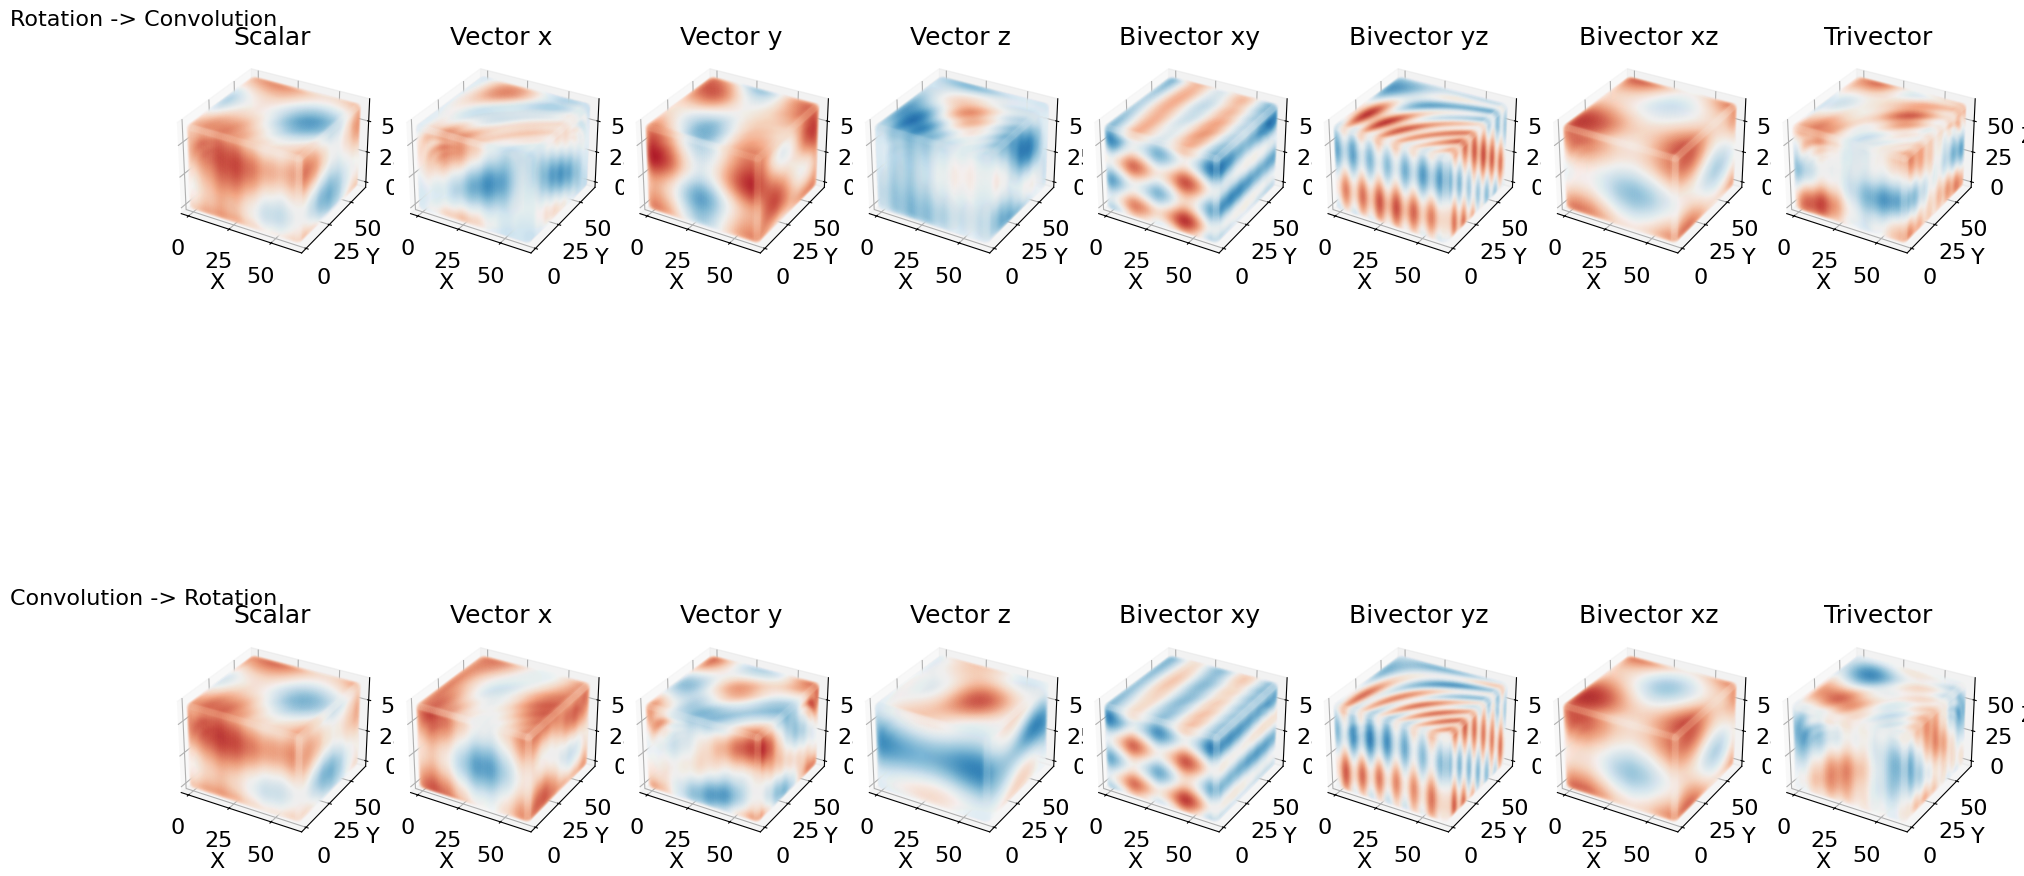

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_comparison(tensor1, tensor2):
    """
    Plot two 3D fields side by side for comparison.
    Args:
        tensor1, tensor2: JAX arrays of shape [C, X, Y, Z] to compare
    """
    component_names = [
        "Scalar",
        "Vector x", "Vector y", "Vector z",
        "Bivector xy", "Bivector yz", "Bivector xz",
        "Trivector"
    ]
    
    # Convert JAX arrays to numpy arrays
    tensor1_np = np.array(tensor1)
    tensor2_np = np.array(tensor2)
    
    # Create coordinate grids
    x, y, z = np.meshgrid(
        np.arange(tensor1_np.shape[1]),
        np.arange(tensor1_np.shape[2]),
        np.arange(tensor1_np.shape[3]),
        indexing='ij'
    )
    
    # Create figure with 2x4 subplot grid
    fig, axs = plt.subplots(2, 8, figsize=(20, 15), subplot_kw={'projection': '3d'})

    axs[0, 0].text2D(-0.1, 1.2, "Rotation -> Convolution", 
                     transform=axs[0, 0].transAxes,
                     rotation=0,
                     fontsize=16,
                     ha='center',
                     va='top')
    axs[1, 0].text2D(-0.1, 1.2, "Convolution -> Rotation",
                     transform=axs[1, 0].transAxes,
                     rotation=0,
                     fontsize=16,
                     ha='center',
                     va='top')
    
    # Plot first set (Rotation -> Convolution)
    for i in range(8):
        ax = axs[0, i]  # First row
        
        scalar_field = tensor1_np[i]
        scatter = ax.scatter(
            x.flatten(),
            y.flatten(), 
            z.flatten(),
            c=scalar_field.flatten(),
            cmap='RdBu',
            alpha=0.1
        )
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f"{component_names[i]}")

        
    # Plot second set (Convolution -> Rotation)
    for i in range(8):
        ax = axs[1, i]  # Second row
        
        scalar_field = tensor2_np[i]
        scatter = ax.scatter(
            x.flatten(),
            y.flatten(), 
            z.flatten(),
            c=scalar_field.flatten(),
            cmap='RdBu',
            alpha=0.1
        )
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f"{component_names[i]}")
    
    plt.tight_layout()
    return fig


# Plot comparison
fig = plot_3d_comparison(
    out_rotated_conv_batched.tensor[0],      # Rotation -> Convolution
    out_conv_rotated_batched.tensor[0],      # Convolution -> Rotation
)

plt.show()

In [14]:
# Compute relative error for cconv

epsilon = 1e-10  # Small constant
relative_error_batched = torch.abs(
    out_rotated_conv_batched.tensor - out_conv_rotated_batched.tensor
) / (torch.abs(out_rotated_conv_batched.tensor + out_conv_rotated_batched.tensor) + epsilon)

# display up to 5 decimal places
print(f"Relative error (mean): {relative_error_batched.mean().item():.1e}")
print(f"Relative error (max): {relative_error_batched.max().item():.1e}")

Relative error (mean): 3.4e+00
Relative error (max): 3.2e+05
